# 학습된 MPG 예측 모델을 바탕으로 Parital Dependency plot을 그려보자

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


## 학습 데이터 로딩

In [2]:
normed_train_dataset = pd.read_pickle('train_dataset.pickle')
train_labels = pd.read_pickle('train_labels.pickle')
normed_train_dataset.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852


## 모델 로딩

In [3]:
model = keras.models.load_model('auto-mpg.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


## Partial Dependence Plot (PDP)

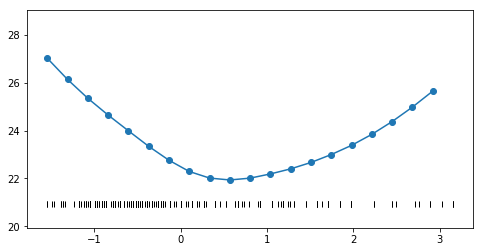

In [99]:
def make_intervals(min_val, max_val, n_interval):
    step = (max_val - min_val) / n_interval
    intervals = [ (min_val+i*step, min_val+(i+1)*step) for i in range(n_interval)]
    return intervals

def partial_dependency_plot(feature_name, n_interval, features):
    stats = features[feature_name].describe()
    intervals = make_intervals(stats['min'], stats['max'], n_interval)
    
    # for each use of lower bound in intervals, 
    x_ = [ lower for lower, upper in intervals ]
    y_ = []
    for lower, upper in intervals:
        
        # make artificial features with replacing feature value with lower bound value
        artificial_features = features.copy()
        artificial_features[feature_name] = lower
        
        # make predictions over artifically created features
        predictions = model.predict(artificial_features).flatten()
        avg_prediction = np.average(predictions)
        y_.append(avg_prediction)
    
    fig, ax = plt.subplots(figsize=(8,4))
    
    # draw curve for avg prediction
    ax.plot(x_, y_, '-o')
    
    # draw original feature distribution as rugged plot
    ax.plot(features[feature_name], [min(y_)-1]*len(features), '|', color='k')

    plt.ylim(min(y_)-2, max(y_)+2)
    plt.show()

partial_dependency_plot('Horsepower', 20, normed_train_dataset)

## Individual Conditional Expectation (ICE) Plot

number of samples to be drawn is 31


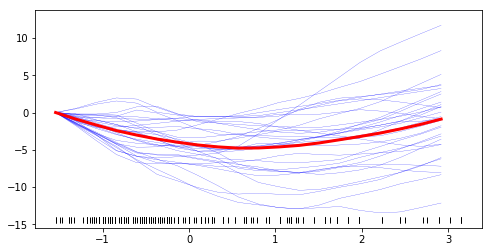

In [112]:
import math
pd.options.mode.chained_assignment = None

def individual_conditional_expectation_plot(feature_name, n_interval, features, sample_ratio, is_centered=False):
    
    assert sample_ratio < 1.0, 'sample ratio should be less than 1.0'

    
    # make intervals
    stats = features[feature_name].describe()
    intervals = make_intervals(stats['min'], stats['max'], n_interval)
    
    # initialize plot
    fig, ax = plt.subplots(figsize=(8,4))

    # draw sample
    samples = features.sample(math.floor(len(features)*sample_ratio))
    print(f'number of samples to be drawn is {len(samples)}')
    
    # feature domain values would be list of lower of interval
    x_ = [ lower for lower, upper in intervals ]
    y_ = []
    for i in range(len(samples)):
        y_i = []
        
        # make dataset in which a row was duplicated over the length of feature domain values
        indices = np.array([i]).repeat(len(x_))
        dup_features = samples.iloc[indices]
        
        # replace each of row by given feature domain values
        dup_features[feature_name] = x_
        
        # make predictions over artifically created features
        predictions = model.predict(dup_features)
        
        # centering to first element in y
        if is_centered:
            y = np.squeeze(np.array(predictions))
            predictions = y[:] - y[0]
            predictions = predictions.tolist()
        
        y_i.extend(predictions)
        y_.append(y_i)
        
        # draw curve for avg prediction
        ax.plot(x_, y_i, '-', c='b', linewidth=0.2)
    
    
    # make average curve over all curves, and draw it
    all_curves = np.squeeze(np.array(y_))
    avg_curve = np.average(all_curves, axis=0)
    ax.plot(x_, avg_curve, '-', c='r', linewidth=3)
    
    # find minimum of y for drawing rugplot properly
    y_min = np.asscalar(np.min(all_curves))
    y_max = np.asscalar(np.max(all_curves))

    # draw original feature distribution as rugged plot
    ax.plot(features[feature_name], [y_min-1]*len(features), '|', color='k')
    plt.ylim(y_min-2, y_max+2)
    plt.show()

individual_conditional_expectation_plot('Horsepower', 20, normed_train_dataset, 0.1, is_centered=True)

## Marginal Plot

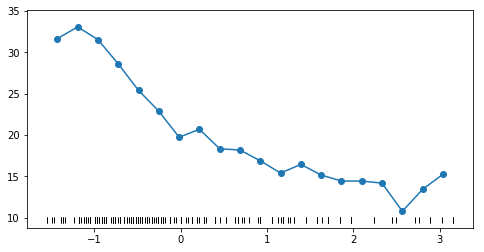

In [113]:
def marginal_plot(feature_name, n_interval, features):
    stats = features[feature_name].describe()
    intervals = make_intervals(stats['min'], stats['max'], n_interval)
    
    x_ = [ (lower+upper)/2 for lower, upper in intervals ]
    
    # for each use of lower bound in intervals, 
    y_ = []
    for lower, upper in intervals:
        
        # select data points within interval
        within_features = features[ (features[feature_name] >= lower) & (features[feature_name] < upper) ]
        
        # if there's none of data points in interval, just use previous one
        if len(within_features) == 0:
            avg_prediction = y_[-1]
        else:
            # make predictions over artifically created features
            predictions = model.predict(within_features)
            avg_prediction = np.average(predictions)
        y_.append(avg_prediction)
    
    fig, ax = plt.subplots(figsize=(8,4))
    
    # draw curve for avg prediction
    ax.plot(x_, y_, '-o')
    
    # draw original feature distribution as rugged plot
    ax.plot(features[feature_name], [min(y_)-1]*len(features), '|', color='k')

    plt.ylim(min(y_)-2, max(y_)+2)
    plt.show()

marginal_plot('Horsepower', 20, normed_train_dataset)

## Accumulated Local Effects (ALE) Plot

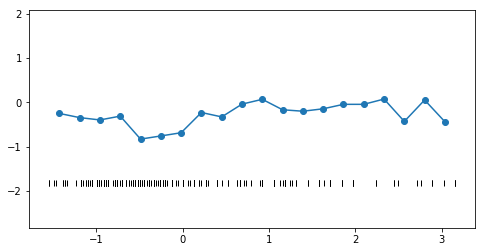

In [114]:
def accumulated_local_effect_plot(feature_name, n_interval, features):
    stats = features[feature_name].describe()
    intervals = make_intervals(stats['min'], stats['max'], n_interval)
    
    x_ = [ (lower+upper)/2 for lower, upper in intervals ]
    
    # for each use of lower bound in intervals, 
    y_ = []
    for lower, upper in intervals:
        
        # select data points within interval
        within_features = features[ (features[feature_name] >= lower) & (features[feature_name] < upper) ]
        

        
        # if there's none of data points in interval, just use previous one
        if len(within_features) == 0:
            avg_prediction = y_[-1]
        else:
            
            def project_and_predict_avg(features, feature_name, projected_value):
                # project onto the value 
                projected_features = features.copy()
                projected_features[feature_name] = projected_value
                
                # make predictions over artifically created features
                predictions = model.predict(projected_features)
                return np.average(predictions)
            
            lower_avg_prediction = project_and_predict_avg(within_features, feature_name, lower)
            upper_avg_prediction = project_and_predict_avg(within_features, feature_name, upper)
            avg_prediction = upper_avg_prediction - lower_avg_prediction
        
        y_.append(avg_prediction)
    
    fig, ax = plt.subplots(figsize=(8,4))
    
    # draw curve for avg prediction
    ax.plot(x_, y_, '-o')
    
    # draw original feature distribution as rugged plot
    ax.plot(features[feature_name], [min(y_)-1]*len(features), '|', color='k')

    plt.ylim(min(y_)-2, max(y_)+2)
    plt.show()

accumulated_local_effect_plot('Horsepower', 20, normed_train_dataset)